Playpen to get the KS_Test working without plt or numpy making bins

0.4885904524294499


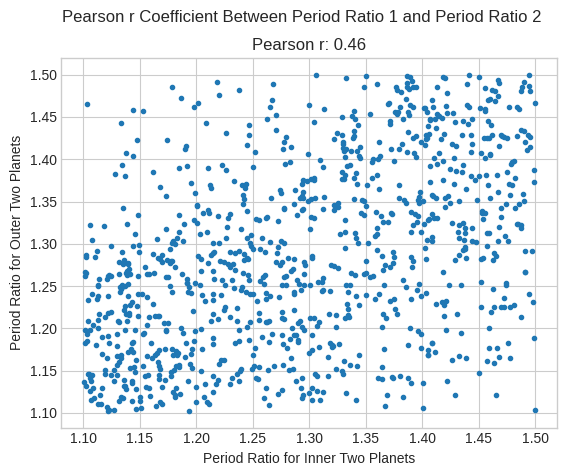

In [110]:
#Playing with Weiss's results

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
%matplotlib inline
plt.style.use('seaborn-whitegrid')

mean = 1.0
#Pearson R: 5
smigma = 5


#Construct First Population
first_population = np.random.uniform(1.1,1.5,1000)
first_population = np.sort(first_population)


second_population = []
for i in first_population:
    temp = 0
    while ( (temp < 1.1) or (temp > 1.5)):
        temp = i*np.random.normal(1,0.1161)
    
    second_population.append(temp)

my_rho = np.corrcoef(first_population, second_population)

print(pearson_r)

pearson_r = my_rho[0][1]
plt.plot(first_population, second_population, 'o', markersize = 3)
plt.xlabel("Period Ratio for Inner Two Planets")
plt.ylabel("Period Ratio for Outer Two Planets")
plt.title("Pearson r: 0.46")
plt.suptitle('Pearson r Coefficient Between Period Ratio 1 and Period Ratio 2')
plt.show()


#plist = lognorm.rvs(s=smigma, scale=mean, size=1000000)



#plt.hist(plist,bins = np.linspace(0.25,4,100), histtype=u'step')
#plt.xscale('log')
#plt.show()



















In [93]:
#Variables to play with, eventually will be deprecated:
bin_number = 30

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from scipy.stats import lognorm
import math
import rebound
import random
from numpy.random import seed, random
from scipy.stats import rayleigh
from scipy.stats import norm
import itertools
from spock import FeatureClassifier
from decimal import Decimal
import pandas as pd

%matplotlib inline

fmodel = FeatureClassifier()
earth_mass = 5.97219*10**24
sun_mass = 1.981 * 10**30
mass_ratio = earth_mass/sun_mass


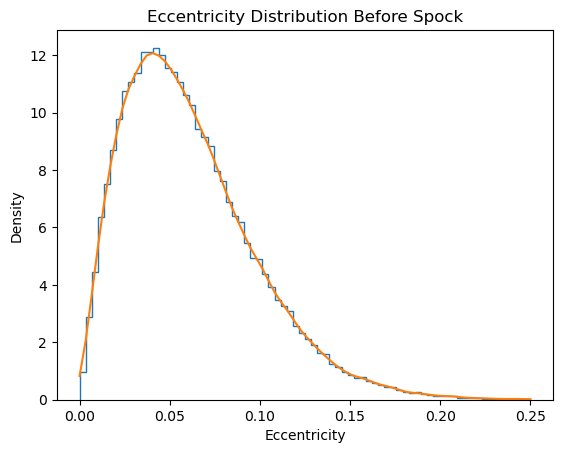

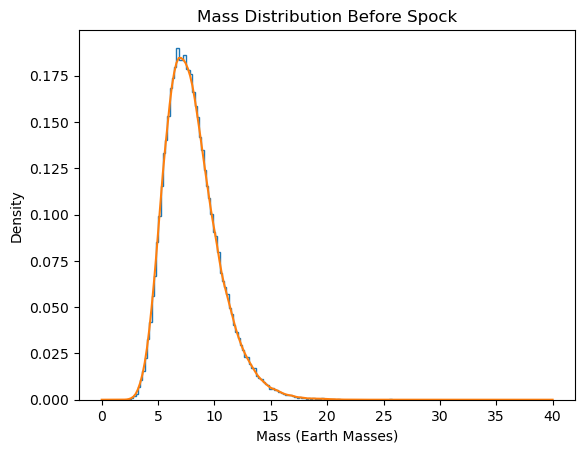

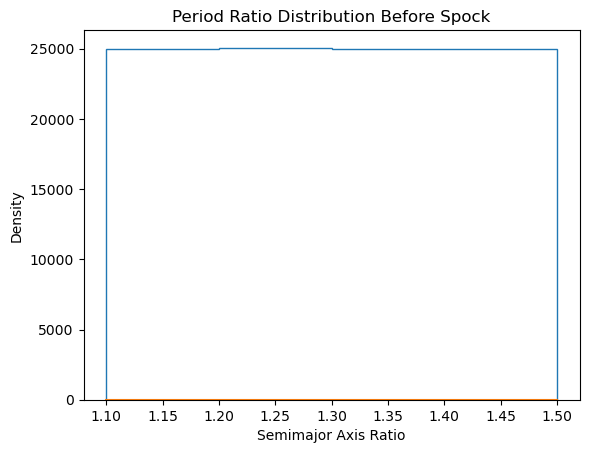

In [95]:
"""
Initialize the original population
"""

num_iter =100000
e_mean = 0.049      #0.02632     #settings["planetary_system"]["mean_e"]
#0.013
e_error=  0.013     #settings["planetary_system"]["e_error"]
m_mean =  7.7         #Wu 2019 Mass and Mass Scalings of Super Earths 
m_error =  0.29    #settings["planetary_system"]["m_error"]
                    #Distribution of period ratios is uniform
p_min = 1.1
p_max = 1.5

e_list = []
p_list = []
m_list = lognorm.rvs(s=m_error, scale=m_mean, size=num_iter) 

for m in m_list:
    if m < 0:
        m_list.remove(m)
        
for i in range(num_iter):
    #Generate p_ratio
    p = np.random.uniform(p_min,p_max)
    p_list.append(p)

    
while len(e_list) < num_iter:
    #Generate e from Rayleigh Distribution
    scale = np.random.normal(e_mean, e_error)
    if scale < 0:
        scale = 0
    e = np.random.rayleigh(scale = scale)
    if not (e < 0 or e > 1):
        e_list.append(e)

density = stats.gaussian_kde(e_list)
n, x, _ = plt.hist(e_list, bins=np.linspace(0, 0.25, 75),
                   histtype=u'step', density=True)  
plt.plot(x, density(x))

plt.title("Eccentricity Distribution Before Spock")
plt.xlabel("Eccentricity")
plt.ylabel("Density")
plt.show()

density = stats.gaussian_kde(m_list)
n, x, _ = plt.hist(m_list,  bins=np.linspace(0, 40, 200),
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.title("Mass Distribution Before Spock")
plt.xlabel("Mass (Earth Masses)")
plt.ylabel("Density")
#plt.xscale("log")
plt.show()


n, x, _ = plt.hist(p_list, bins=np.linspace(1.1,1.5, 5),
                   histtype=u'step', density = False)
plt.plot(x, density(x))
plt.title("Period Ratio Distribution Before Spock")
plt.xlabel("Semimajor Axis Ratio")
plt.ylabel("Density")
plt.show()





In [96]:
#This only needs to be run once
#This initializes the lists that populations can be added into
spock_e_list = []
spock_p_list = []
spock_m_list = []
p_weight_array = []
triple_weight_array = []
prob_list = []
iter_list = []

In [97]:
#LOADS OBSERVATIONAL DATA

pairs = pd.read_csv('exoarchive_planet_pairs.csv', index_col=0)
res2 = np.load('res.npy', allow_pickle=True)

bins=np.linspace(1.1, 1.50, bin_number) 
mask = pairs['Pratio'] < 1.5
count, edges = np.histogram(pairs['Pratio'][mask], bins=bins)
obs_period_values = count
pdf = count/sum(count)
observed_norm_cumulative = np.cumsum(pdf)
observed_period_pdf = count
observed_period_cdf = observed_norm_cumulative


In [104]:
"""
Run Program

"""

print("Program Started")

for j in range(20):
    print(str(j))
    sim_list = []
    for index in range(20):
        i = int(np.random.uniform(0,10000))
        temp_e1 = e_list[3*i]
        temp_e2 = e_list[3*i+1]
        temp_e3 = e_list[3*i+2]

        temp_m1 = m_list[3*i] 
        temp_m2 = m_list[3*i+1] 
        temp_m3 = m_list[3*i+2] 

        temp_p1 = p_list[int(np.random.uniform(0,num_iter))]

        temp_sim = rebound.Simulation()
        temp_sim.add(m=1) 

        temp_sim.add(m=temp_m1*mass_ratio, P = 1, e = temp_e1)
        temp_sim.add(m=temp_m2*mass_ratio, P = temp_p1, e = temp_e2)
        temp_sim.add(m=temp_m3*mass_ratio, P = temp_p1**2, e = temp_e3)

        spock_e_list.append(temp_e1)
        spock_e_list.append(temp_e2)
        spock_e_list.append(temp_e3)
        spock_m_list.append(temp_m1)
        spock_m_list.append(temp_m2)
        spock_m_list.append(temp_m3)
        spock_p_list.append(temp_p1)


        sim_list.append(temp_sim)

    temp_p_weight_array = fmodel.predict_stable(sim_list)
    temp_triple_weight_array = np.repeat(temp_p_weight_array, 3)
    p_weight_array = np.concatenate([p_weight_array, temp_p_weight_array])
    triple_weight_array = np.concatenate([triple_weight_array, temp_triple_weight_array])
    
    spock_p_values, spock_p_base = np.histogram(spock_p_list , weights = p_weight_array, bins=np.linspace(1.1, 1.50, bin_number))
    spock_p_cumsum = np.cumsum(spock_p_values)/max(np.cumsum(spock_p_values))

    
    
    
    
    
    
    
    estimator = sns.distributions.ECDF('proportion', complementary=False)
    stat, p_vals = estimator(spock_p_list, weights=p_weight_array)
    period_ratios = stat
    
    #Here we calculate the p value and add it to our prob_list

    ksprob = scipy.stats.kstest(period_ratios, observed_period_cdf, args = (), alternative = 'two-sided',
                                method = 'exact')    
    pvalue = ksprob[1]
    prob_list.append(pvalue)
    iter_list.append(len(spock_p_list))

print("done")

Program Started
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done


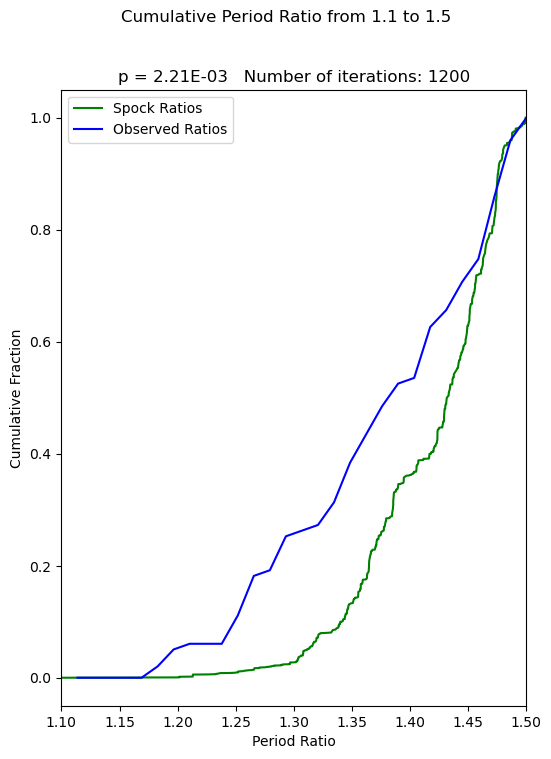

<Figure size 1000x100 with 0 Axes>

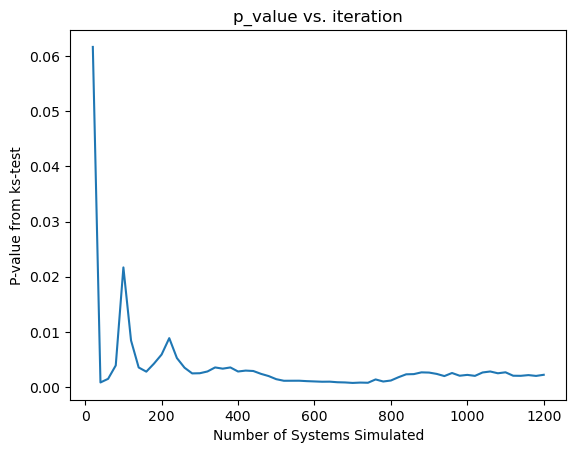

In [105]:
#Below we generate the plots for our population

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(6)




plt.plot(p_vals, period_ratios, c = 'green')
plt.plot(edges[1:], observed_period_cdf, c = 'blue')
plt.legend(["Spock Ratios", "Observed Ratios"])
plt.suptitle("Cumulative Period Ratio from 1.1 to 1.5")
plt.title("p = " + '%.2E' % Decimal( str(prob_list[-1])  ) + "   Number of iterations: " + str(len(spock_p_list)))
plt.xlabel("Period Ratio")
plt.ylabel("Cumulative Fraction")
plt.xlim(1.1,1.5)
plt.figure(figsize=(10, 1))
plt.show()


plt.plot(iter_list,prob_list)
plt.title("p_value vs. iteration")
plt.xlabel("Number of Systems Simulated")
plt.ylabel("P-value from ks-test")
plt.show()









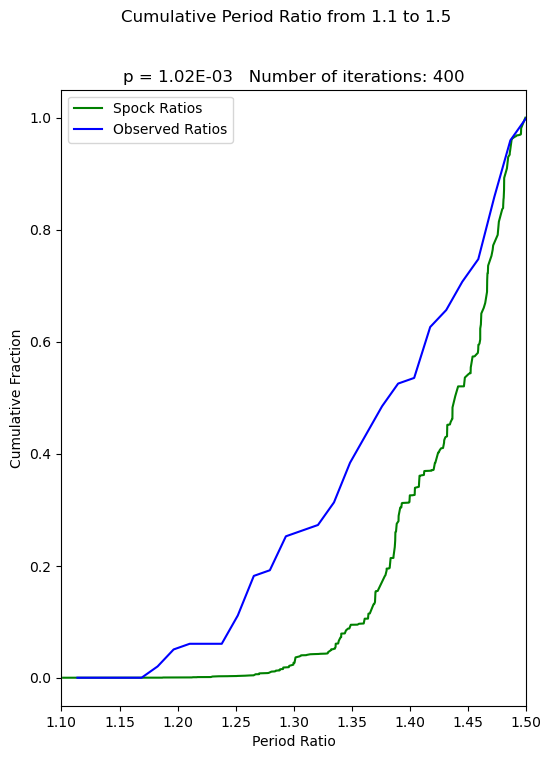

<Figure size 1000x100 with 0 Axes>

In [92]:
#Create Ks_Test that can work with the following lists:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



#This is the Spock Data
sample = spock_p_list
weights = p_weight_array


#This is the observed data
obs_period_values = obs_period_values



estimator = sns.distributions.ECDF('proportion', complementary=False)
stat, p_vals = estimator(sample, weights=weights)
period_ratios = stat

estimator = sns.distributions.ECDF('proportion', complementary=False)
stat, obs_vals = estimator(obs_period_values)
oprat = stat



#Here we perform the KS Test
ksprob = scipy.stats.kstest(period_ratios, observed_period_cdf, args = (), alternative = 'two-sided',
                                method = 'exact')  



prob = ksprob[1]


#Below we generate the plots for our population

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(6)

plt.plot(vals, period_ratios, c = 'green')
plt.plot(edges[1:], observed_period_cdf, c = 'blue')
plt.legend(["Spock Ratios", "Observed Ratios"])
plt.suptitle("Cumulative Period Ratio from 1.1 to 1.5")
plt.title("p = " + '%.2E' % Decimal( str(prob)  ) + "   Number of iterations: " + str(len(spock_p_list)))
plt.xlabel("Period Ratio")
plt.ylabel("Cumulative Fraction")
plt.xlim(1.1,1.5)
plt.figure(figsize=(10, 1))
plt.show()












